Further clean some columns and focus on
consumption-for-eg-btu >>>> electricity generation | ash-content | heat-content

In [172]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sqlalchemy import create_engine

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [229]:
db = '../static/data/eia_electric.sqlite'

In [230]:
engine = create_engine(f'sqlite:///{db}')
conn = engine.connect()

In [231]:
data = pd.read_sql('SELECT * FROM epo', conn, parse_dates = ['period'])
data.head()

,period,energySource,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,fossil fuels,3.12,281.61,10.36,7.00,28830.19,9.85,266757.42,23911.23,0.82,291.97
1,2008-01-01,others,0.00,251.47,0.88,0.00,23851.43,0.00,0.00,0.00,0.00,252.35
2,2008-01-01,renewables,2.65,14.39,4.72,1.06,1313.12,1.05,466.37,77.00,0.09,19.11
3,2008-02-01,fossil fuels,3.03,193.27,8.91,6.69,19511.71,11.03,191351.71,17899.89,1.16,202.18
4,2008-02-01,others,0.00,2.76,0.69,0.00,200.83,0.00,0.00,0.00,0.00,3.46


In [232]:
engine.dispose()

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   period                  539 non-null    datetime64[ns]
 1   energySource            539 non-null    object        
 2   ash-content             539 non-null    float64       
 3   consumption-for-eg-btu  539 non-null    float64       
 4   consumption-uto-btu     539 non-null    float64       
 5   cost-per-btu            539 non-null    float64       
 6   generation              539 non-null    float64       
 7   heat-content            539 non-null    float64       
 8   receipts-btu            539 non-null    float64       
 9   stocks                  539 non-null    float64       
 10  sulfur-content          539 non-null    float64       
 11  total-consumption-btu   539 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memor

In [234]:
data.describe()

,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
count,539,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,2015-06-13 00:58:46.530612224,1.398664,112.356048,3.799184,1.301429,11502.210353,6.170353,51521.374453,3992.134972,0.319147,116.155325
min,2008-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011-09-16 00:00:00,0.000000,23.200000,0.700000,0.000000,2612.025000,1.700000,0.000000,0.000000,0.000000,26.305000
50%,2015-06-01 00:00:00,1.270000,98.700000,2.980000,0.040000,10471.640000,7.020000,151.880000,17.300000,0.050000,101.010000
75%,2019-03-01 00:00:00,2.460000,180.145000,5.675000,2.670000,18276.635000,9.660000,96512.770000,6209.960000,0.740000,183.910000
max,2022-12-01 00:00:00,6.860000,732.900000,22.340000,9.120000,78435.150000,21.800000,656198.560000,59446.550000,1.630000,741.530000
std,NaN,1.346421,96.860166,3.683353,2.019227,9699.352909,4.297033,86185.553369,7335.054764,0.437067,97.334156


In [235]:
# Create DF of each energySource
ff_df = data.loc[data['energySource'] == 'fossil fuels'].drop(columns = ['energySource']).reset_index(drop = True)
re_df = data.loc[data['energySource'] == 'renewables'].drop(columns = ['energySource']).reset_index(drop = True)
oth_df = data.loc[data['energySource'] == 'others'].drop(columns = ['energySource']).reset_index(drop = True)

In [236]:
# View the DF
display(ff_df.head())
display(re_df.head())
display(oth_df.head())

,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,3.12,281.61,10.36,7.00,28830.19,9.85,266757.42,23911.23,0.82,291.97
1,2008-02-01,3.03,193.27,8.91,6.69,19511.71,11.03,191351.71,17899.89,1.16,202.18
2,2008-03-01,3.10,313.18,8.63,7.17,31611.79,10.60,331404.22,28144.92,0.96,321.80
3,2008-04-01,2.40,60.49,6.19,7.92,6606.74,10.13,72365.60,6495.41,0.98,66.68
4,2008-05-01,3.14,216.15,6.59,8.73,22015.65,9.24,237419.53,19973.35,0.87,222.75


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,2.65,14.39,4.72,1.06,1313.12,1.05,466.37,77.00,0.09,19.11
1,2008-02-01,1.62,18.93,5.51,0.20,1774.69,0.51,108.87,0.01,0.04,24.44
2,2008-03-01,1.73,15.67,3.94,0.69,1394.62,0.82,274.59,32.43,0.10,19.61
3,2008-04-01,2.86,14.92,1.74,0.84,1378.31,0.99,609.34,57.25,0.13,16.67
4,2008-05-01,1.94,21.32,5.20,0.70,2066.95,0.84,230.97,22.33,0.08,26.51


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,0.0,251.47,0.88,0.0,23851.43,0.0,0.0,0.0,0.0,252.35
1,2008-02-01,0.0,2.76,0.69,0.0,200.83,0.0,0.0,0.0,0.0,3.46
2,2008-03-01,0.0,60.79,0.68,0.0,5798.20,0.0,0.0,0.0,0.0,61.48
3,2008-04-01,0.0,295.20,0.29,0.0,28135.96,0.0,0.0,0.0,0.0,295.50
4,2008-05-01,0.0,187.98,0.35,0.0,17838.57,0.0,0.0,0.0,0.0,188.33


In [237]:
# Check dType for one to verify the data types are correct
ff_df.dtypes

period                    datetime64[ns]
ash-content                      float64
consumption-for-eg-btu           float64
consumption-uto-btu              float64
cost-per-btu                     float64
generation                       float64
heat-content                     float64
receipts-btu                     float64
stocks                           float64
sulfur-content                   float64
total-consumption-btu            float64
dtype: object

In [238]:
# Display the DFs' correlation using .corr()
display(ff_df.corr())
display(re_df.corr())
display(oth_df.corr())

,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,1.000000,-0.223419,-0.223125,0.110051,-0.048894,-0.145804,-0.117268,-0.263106,-0.148666,-0.363173,-0.214620
ash-content,-0.223419,1.000000,0.568564,0.138919,0.072511,0.545725,0.550906,0.591418,0.390106,0.452431,0.565889
consumption-for-eg-btu,-0.223125,0.568564,1.000000,0.327966,0.199867,0.993872,0.289069,0.984236,0.702135,0.261848,0.999083
consumption-uto-btu,0.110051,0.138919,0.327966,1.000000,0.088660,0.366237,0.128286,0.347304,0.204576,-0.039364,0.368110
cost-per-btu,-0.048894,0.072511,0.199867,0.088660,1.000000,0.193167,0.067737,0.218787,0.418969,-0.156015,0.200727
generation,-0.145804,0.545725,0.993872,0.366237,0.193167,1.000000,0.269589,0.976380,0.688588,0.241774,0.994786
heat-content,-0.117268,0.550906,0.289069,0.128286,0.067737,0.269589,1.000000,0.291214,0.294135,0.554308,0.290321
receipts-btu,-0.263106,0.591418,0.984236,0.347304,0.218787,0.976380,0.291214,1.000000,0.724769,0.264680,0.984444
stocks,-0.148666,0.390106,0.702135,0.204576,0.418969,0.688588,0.294135,0.724769,1.000000,0.007681,0.700325
sulfur-content,-0.363173,0.452431,0.261848,-0.039364,-0.156015,0.241774,0.554308,0.264680,0.007681,1.000000,0.255934


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,1.000000,-0.362410,0.245959,-0.140086,-0.640844,0.538089,0.197411,-0.479281,-0.123478,-0.436934,0.213636
ash-content,-0.362410,1.000000,0.151387,0.153244,0.304149,0.083253,0.159046,0.768939,0.387898,0.864441,0.172567
consumption-for-eg-btu,0.245959,0.151387,1.000000,0.111968,-0.193550,0.812651,-0.027492,0.152448,0.187260,0.189307,0.985386
consumption-uto-btu,-0.140086,0.153244,0.111968,1.000000,0.041003,0.065776,0.085809,0.130993,-0.008537,0.047580,0.279597
cost-per-btu,-0.640844,0.304149,-0.193550,0.041003,1.000000,-0.294660,-0.279430,0.427380,0.566893,0.427009,-0.180028
generation,0.538089,0.083253,0.812651,0.065776,-0.294660,1.000000,-0.040722,0.073594,0.214217,0.101619,0.796444
heat-content,0.197411,0.159046,-0.027492,0.085809,-0.279430,-0.040722,1.000000,-0.016172,-0.198118,0.112128,-0.011790
receipts-btu,-0.479281,0.768939,0.152448,0.130993,0.427380,0.073594,-0.016172,1.000000,0.428144,0.845987,0.169817
stocks,-0.123478,0.387898,0.187260,-0.008537,0.566893,0.214217,-0.198118,0.428144,1.000000,0.459718,0.179419
sulfur-content,-0.436934,0.864441,0.189307,0.047580,0.427009,0.101619,0.112128,0.845987,0.459718,1.000000,0.191125


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,1.000000,NaN,-0.122474,-0.133152,NaN,-0.120724,0.366916,NaN,NaN,NaN,-0.123196
ash-content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
consumption-for-eg-btu,-0.122474,NaN,1.000000,-0.234429,NaN,0.999976,-0.420156,NaN,NaN,NaN,0.999991
consumption-uto-btu,-0.133152,NaN,-0.234429,1.000000,NaN,-0.235154,-0.043995,NaN,NaN,NaN,-0.230246
cost-per-btu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
generation,-0.120724,NaN,0.999976,-0.235154,NaN,1.000000,-0.420669,NaN,NaN,NaN,0.999963
heat-content,0.366916,NaN,-0.420156,-0.043995,NaN,-0.420669,1.000000,NaN,NaN,NaN,-0.420789
receipts-btu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stocks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sulfur-content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [406]:
display(ff_df.describe())
display(re_df.describe())
display(oth_df.describe())

,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
count,180,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,2015-06-16 20:32:00,2.864556,152.163667,7.422556,3.702944,16556.705000,9.687500,154098.710556,11933.654222,0.902167,159.587111
min,2008-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011-09-23 12:00:00,2.350000,91.985000,5.082500,2.680000,10466.730000,8.935000,96571.260000,6237.505000,0.740000,100.505000
50%,2015-06-16 00:00:00,2.840000,146.275000,6.990000,3.600000,16157.020000,9.725000,147121.350000,10903.990000,0.890000,154.105000
75%,2019-03-08 18:00:00,3.292500,193.765000,9.582500,4.697500,21165.610000,10.510000,198964.917500,16428.012500,1.050000,202.045000
max,2022-12-01 00:00:00,6.860000,732.900000,22.340000,9.120000,78435.150000,14.210000,656198.560000,59446.550000,1.630000,741.530000
std,NaN,0.862334,82.097216,3.779170,1.854811,8707.111858,1.409121,80244.843692,8154.182716,0.241590,83.413068


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
count,180,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,2015-06-16 20:32:00,1.323667,21.862167,3.346944,0.194111,2462.544889,1.611667,179.182944,20.572167,0.053500,25.208667
min,2008-01-01 00:00:00,0.000000,0.520000,0.000000,0.000000,19.390000,0.500000,0.000000,0.000000,0.000000,0.520000
25%,2011-09-23 12:00:00,0.860000,15.365000,2.227500,0.020000,1661.160000,1.367500,88.302500,2.862500,0.030000,18.815000
50%,2015-06-16 00:00:00,1.270000,20.860000,3.180000,0.050000,2231.920000,1.615000,152.185000,18.065000,0.050000,23.745000
75%,2019-03-08 18:00:00,1.730000,26.907500,4.237500,0.250000,3219.242500,1.832500,257.757500,31.560000,0.072500,30.790000
max,2022-12-01 00:00:00,3.630000,61.400000,9.050000,1.360000,7088.380000,4.750000,828.770000,83.130000,0.170000,63.470000
std,NaN,0.763083,9.335735,1.656457,0.296779,1205.588422,0.521643,138.453886,18.206608,0.033998,9.662679


,period,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
count,179,179.0,179.000000,179.000000,179.0,179.000000,179.000000,179.0,179.0,179.0,179.000000
mean,2015-06-05 08:50:56.983240192,0.0,163.325475,0.610335,0.0,15509.644693,7.217709,0.0,0.0,0.0,163.935642
min,2008-01-01 00:00:00,0.0,0.270000,0.000000,0.0,33.070000,0.000000,0.0,0.0,0.0,1.020000
25%,2011-09-16 00:00:00,0.0,111.115000,0.305000,0.0,10506.990000,5.210000,0.0,0.0,0.0,111.665000
50%,2015-06-01 00:00:00,0.0,167.290000,0.580000,0.0,15932.310000,7.280000,0.0,0.0,0.0,167.960000
75%,2019-02-15 00:00:00,0.0,215.795000,0.825000,0.0,20507.330000,9.395000,0.0,0.0,0.0,216.505000
max,2022-12-01 00:00:00,0.0,506.520000,2.960000,0.0,48344.030000,21.800000,0.0,0.0,0.0,507.520000
std,NaN,0.0,94.841747,0.418915,0.0,9056.858568,4.348614,0.0,0.0,0.0,94.744189


In [239]:
# Check the shapes of our DFs
print(ff_df.shape, re_df.shape, oth_df.shape)

(180, 11) (180, 11) (179, 11)


# FUNCTIONS

In [385]:
def set_scale_df(df, start_pos, end_pos, set_index):
    '''
        Function to scale the data to help reduce biases as part of preprocessing by using MinMaxScaler.
        This is to account for the outliers.
    '''
    cols = list(df)[start_pos:end_pos]
    train_df = df[cols]

    scaler = MinMaxScaler()
    scaler = scaler.fit(train_df)
    
    train_scaled_df = scaler.transform(train_df)
    train_scaled_df = pd.DataFrame(train_scaled_df, columns = cols)
    
    train_scaled_df[set_index] = df[[set_index]]
    train_scaled_df = train_scaled_df.set_index(set_index)
    
    return train_scaled_df

def plot_feature(df, nrows = 1, ncols = 1):
    '''Function to plot the features in a dataframe with time being the index value'''
    fig_ff, axes_ff = plt.subplots(nrows = nrows, ncols = ncols, dpi = 120)
    
    for i, ax in enumerate(axes_ff.flatten()):
        data = df[df.columns[i]]

        ax.plot(data, color = 'red', linewidth = 1)
        ax.set_title(ff_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize = 6)

    plt.tight_layout()

def print_ADF(df):
    '''Function to verify which features in the DF is stationary or nonstationary'''
    cols = list(df)
    ideal_features = []
    
    for col in cols:
        try:
            ad_fuller_result = adfuller(df[col])

            print(f'real {col}')        

            if ad_fuller_result[1] < 0.05:
                print(f'ADF Statistic: {ad_fuller_result[0]}')
                print(f'p-value: {ad_fuller_result[1]}')
                ideal_features.append(col)
            else:
                print(f'p-value: {ad_fuller_result[1]} ==> Non-stationary')
        except:
            print(col) 
            print('Failed to run the ADF test')
        print('-' * 10)
    
    print('Stationary features:', ideal_features)

In [386]:
# Scale the features
ff_train_scaled_df = set_scale_df(ff_df, 1, len(ff_df.columns) + 1, 'period')
re_train_scaled_df = set_scale_df(re_df, 1, len(re_df.columns) + 1, 'period')
oth_train_scaled_df = set_scale_df(oth_df, 1, len(oth_df.columns) + 1, 'period')

In [387]:
# Preview 5 rows of the scaled data
display(ff_train_scaled_df)
display(re_train_scaled_df)
display(oth_train_scaled_df)

,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,0.454810,0.384241,0.463742,0.767544,0.367567,0.693174,0.406519,0.402231,0.503067,0.393740
2008-02-01,0.441691,0.263706,0.398836,0.733553,0.248762,0.776214,0.291606,0.301109,0.711656,0.272652
2008-03-01,0.451895,0.427316,0.386303,0.786184,0.403031,0.745954,0.505036,0.473449,0.588957,0.433968
2008-04-01,0.349854,0.082535,0.277081,0.868421,0.084232,0.712878,0.110280,0.109265,0.601227,0.089922
2008-05-01,0.457726,0.294924,0.294987,0.957237,0.280686,0.650246,0.361811,0.335988,0.533742,0.300392
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.374636,0.282344,0.439570,0.785088,0.308372,0.644616,0.304106,0.145499,0.453988,0.292301
2022-09-01,0.597668,0.099577,0.311101,0.479167,0.118983,0.561576,0.112704,0.019711,0.631902,0.107791
2022-10-01,0.448980,0.186806,0.236795,0.735746,0.205928,0.653765,0.236141,0.173084,0.625767,0.191779


,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,0.730028,0.227825,0.521547,0.779412,0.183015,0.129412,0.562725,0.926260,0.529412,0.295314
2008-02-01,0.446281,0.302398,0.608840,0.147059,0.248310,0.002353,0.131363,0.000120,0.235294,0.379984
2008-03-01,0.476584,0.248850,0.435359,0.507353,0.194544,0.075294,0.331322,0.390112,0.588235,0.303257
2008-04-01,0.787879,0.236531,0.192265,0.617647,0.192237,0.115294,0.735234,0.688680,0.764706,0.256553
2008-05-01,0.534435,0.341656,0.574586,0.514706,0.289654,0.080000,0.278690,0.268615,0.470588,0.412867
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.143251,0.199737,0.335912,0.029412,0.501858,0.287059,0.089892,0.106099,0.117647,0.241461
2022-09-01,0.000000,0.028252,0.251934,0.000000,0.033218,0.216471,0.000000,0.105979,0.000000,0.063542
2022-10-01,0.000000,0.097898,0.564641,0.000000,0.201712,0.261176,0.000000,0.064116,0.000000,0.175854


,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,0.0,0.496198,0.297297,0.0,0.493022,0.000000,0.0,0.0,0.0,0.496209
2008-02-01,0.0,0.004919,0.233108,0.0,0.003473,0.000000,0.0,0.0,0.0,0.004817
2008-03-01,0.0,0.119546,0.229730,0.0,0.119334,0.000000,0.0,0.0,0.0,0.119368
2008-04-01,0.0,0.582578,0.097973,0.0,0.581708,0.000000,0.0,0.0,0.0,0.581402
2008-05-01,0.0,0.370785,0.118243,0.0,0.368560,0.000000,0.0,0.0,0.0,0.369812
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.0,0.431210,0.175676,0.0,0.430846,0.198624,0.0,0.0,0.0,0.430543
2022-09-01,0.0,0.009244,0.000000,0.0,0.004542,0.646789,0.0,0.0,0.0,0.007759
2022-10-01,0.0,0.273600,0.233108,0.0,0.272694,0.286239,0.0,0.0,0.0,0.273346


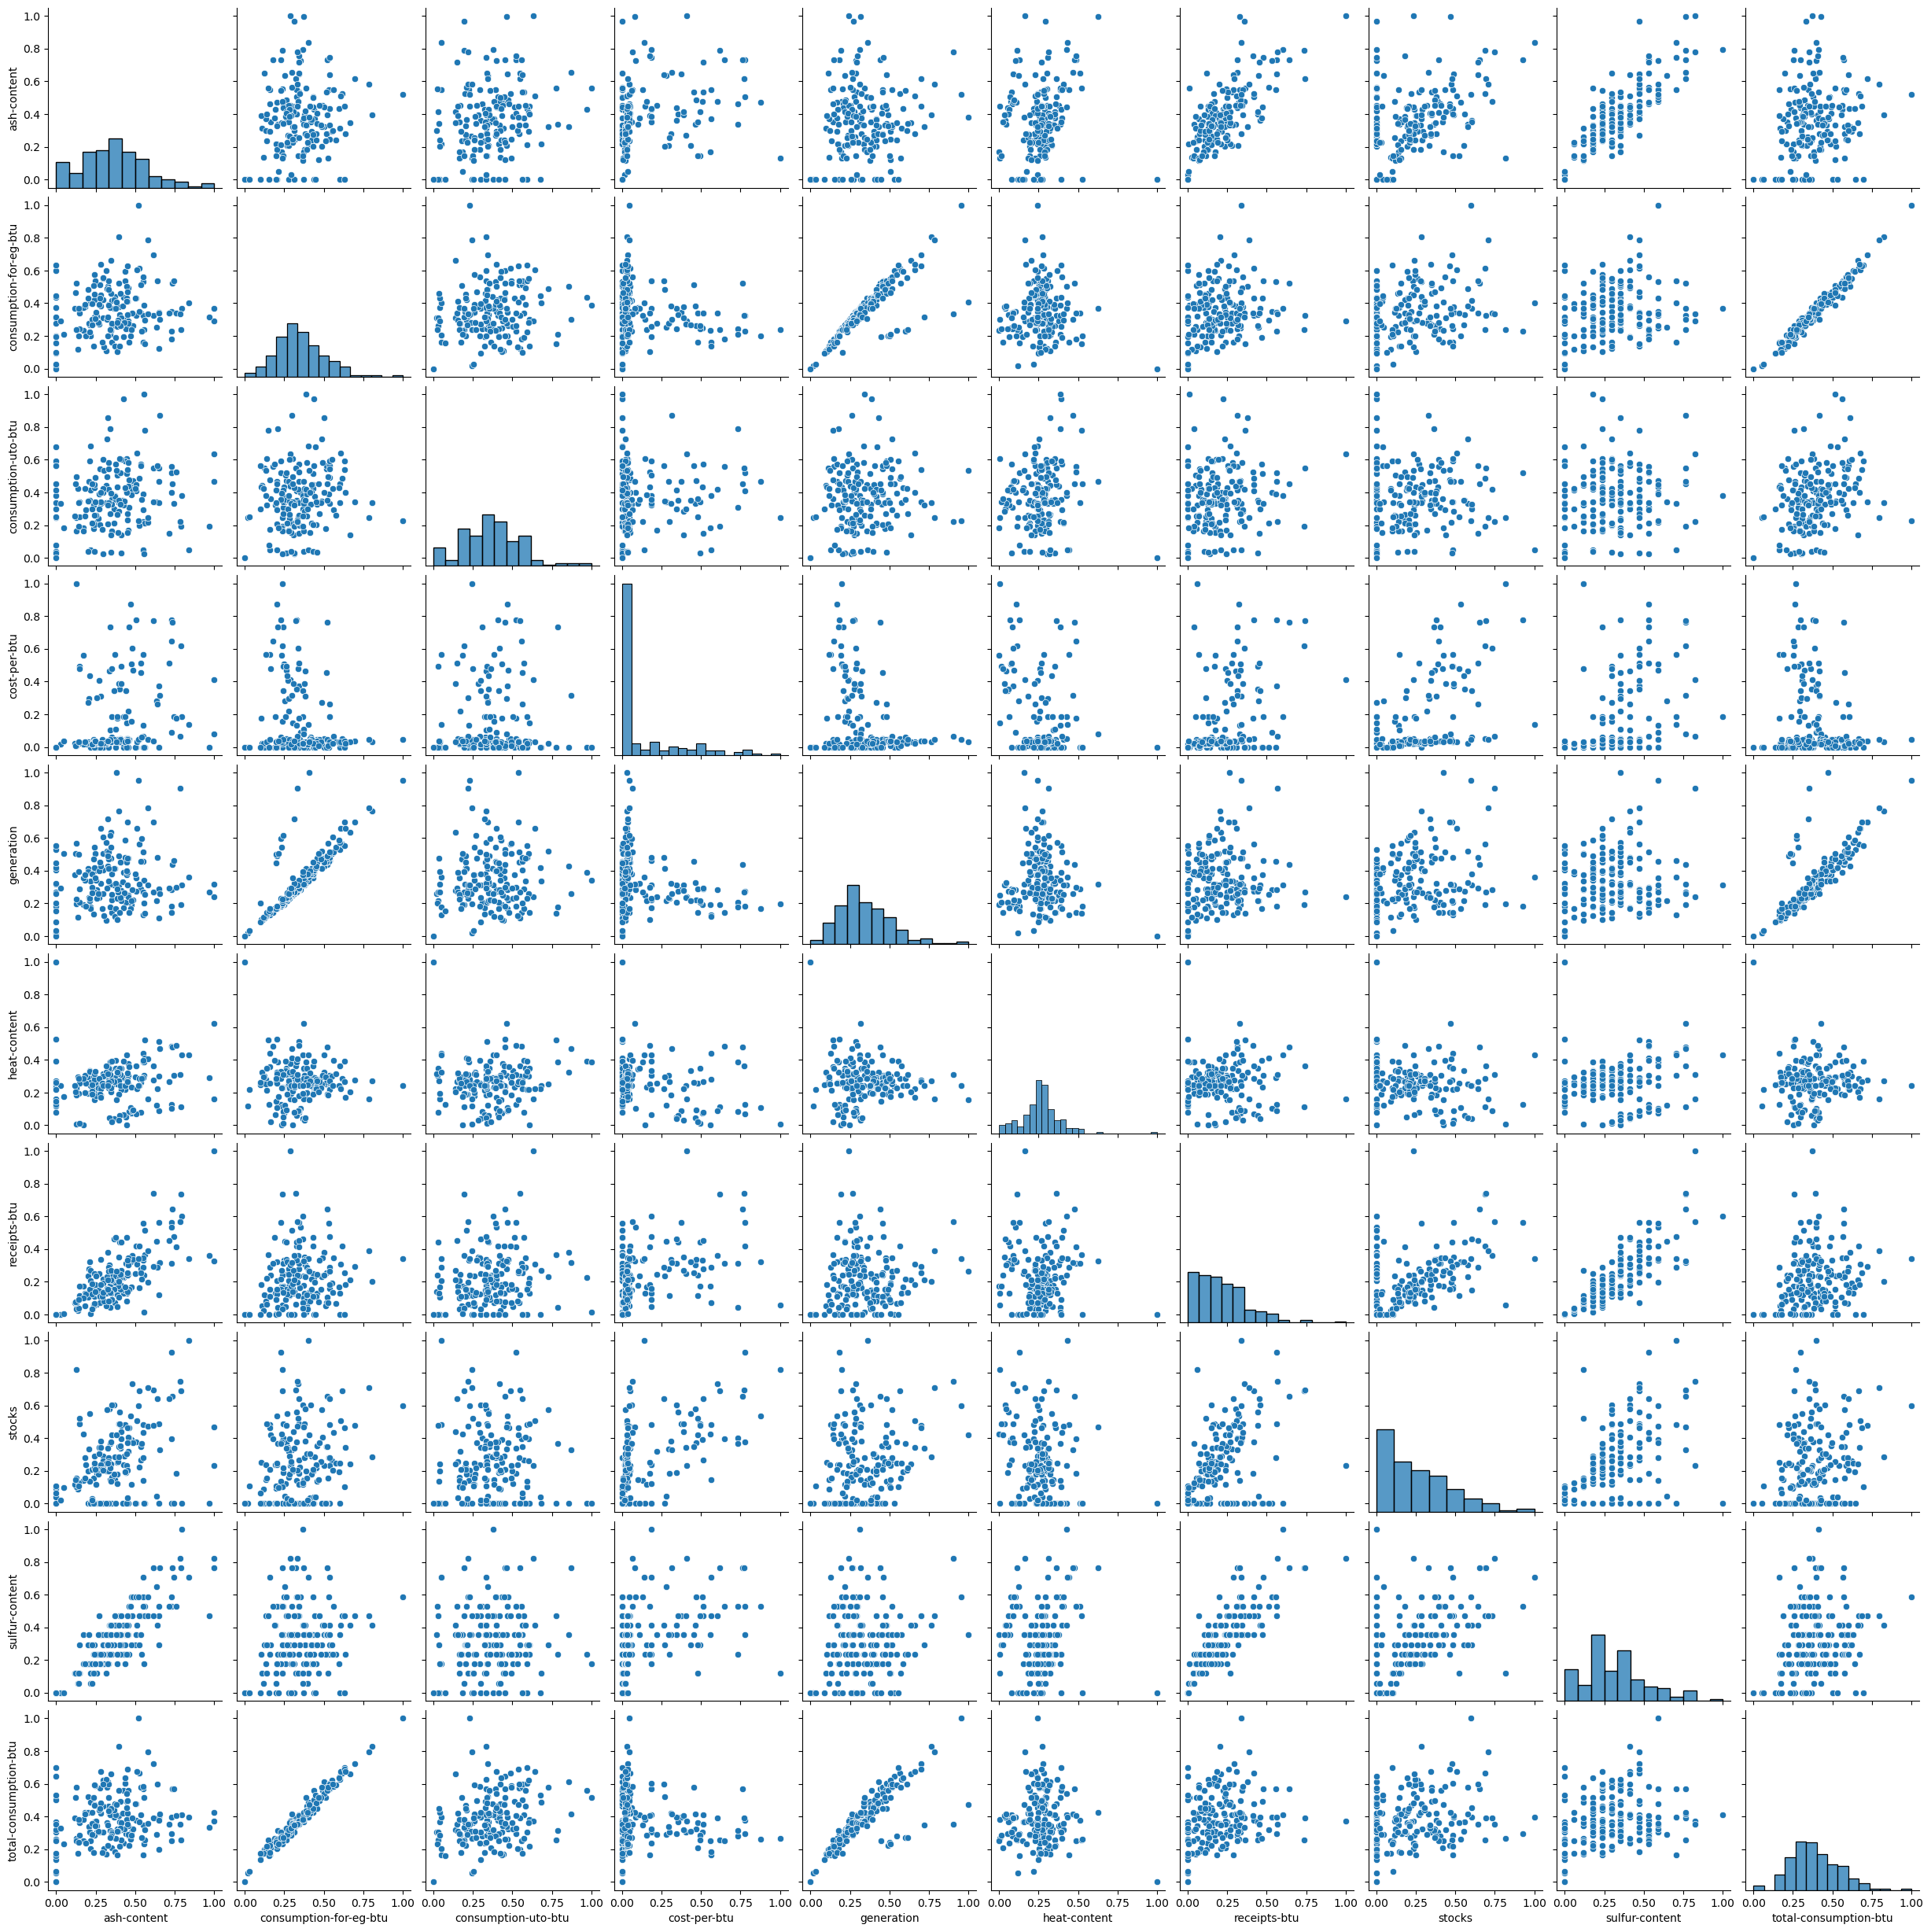

In [455]:
sns.pairplot(re_train_scaled_df, kind = 'scatter')
plt.show()

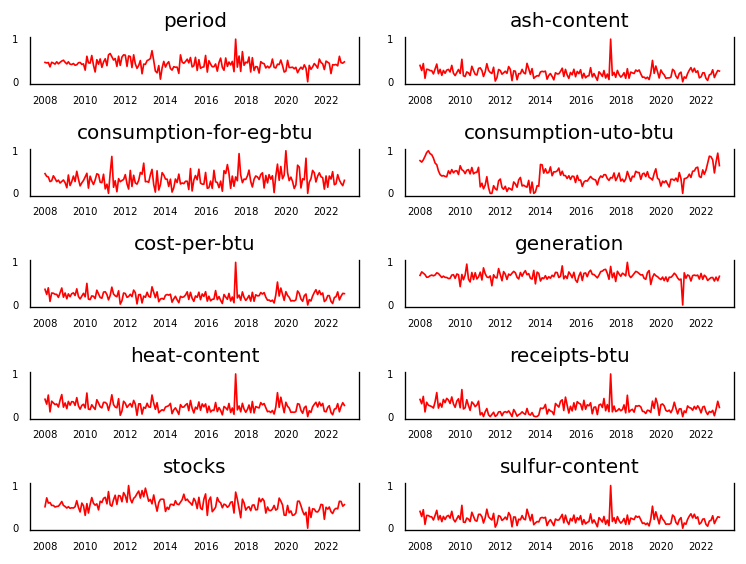

In [388]:
# Plot ff_train_scaled_df's features
plot_feature(ff_train_scaled_df, 5, 2)

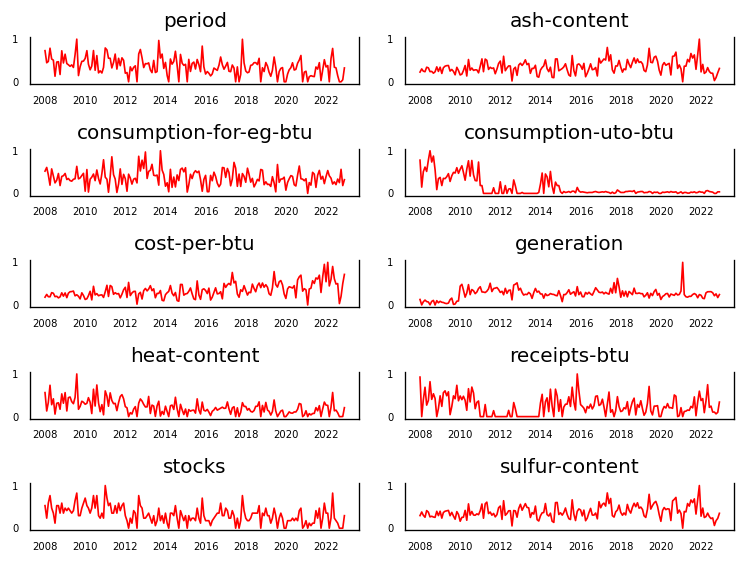

In [389]:
# Plot re_train_scaled_df
plot_feature(re_train_scaled_df, 5, 2)

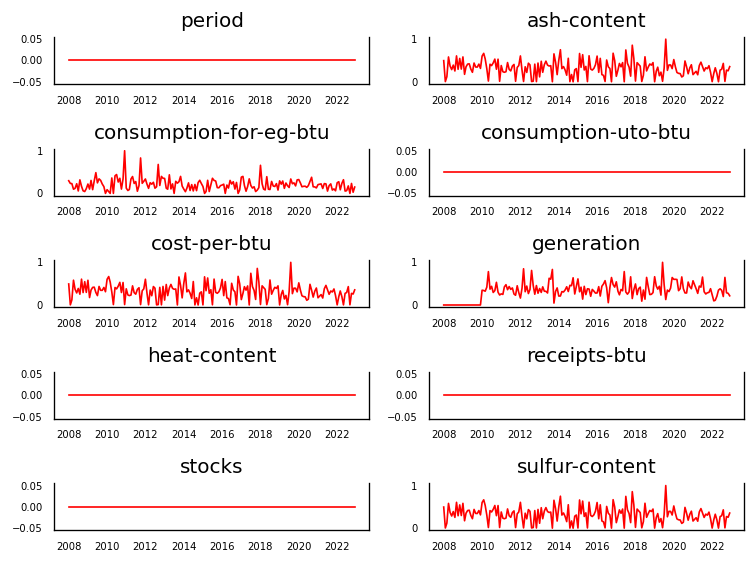

In [390]:
# Plot oth_train_scaled_df's features
plot_feature(oth_train_scaled_df, 5, 2)

### Augmented DIckey-Fuller Test
---
The following features that are best kept so that we may use one model for all energy type are:
* `generation`, `consumption-for-eg`, `consumption-for-eg-btu`, `consumption-uto-btu`, `heat-content`, `total-consumption-btu`

In [438]:
# ADF - Augmented Dickey-Fuller test for ff_train_scaled_df
print_ADF(ff_train_scaled_df)

real ash-content
ADF Statistic: -3.795738549520171
p-value: 0.0029512173741400656
----------
real consumption-for-eg-btu
ADF Statistic: -13.646549550669905
p-value: 1.6155237015266958e-25
----------
real consumption-uto-btu
ADF Statistic: -13.922564596566518
p-value: 5.263143601947506e-26
----------
real cost-per-btu
p-value: 0.061869294001032284 ==> Non-stationary
----------
real generation
ADF Statistic: -13.899101306423558
p-value: 5.778287580899985e-26
----------
real heat-content
ADF Statistic: -6.234560577534988
p-value: 4.8610646440477565e-08
----------
real receipts-btu
ADF Statistic: -13.618731936581327
p-value: 1.8138415629131971e-25
----------
real stocks
ADF Statistic: -4.530713517338304
p-value: 0.0001729826237795207
----------
real sulfur-content
ADF Statistic: -3.428200738746915
p-value: 0.0100342644740008
----------
real total-consumption-btu
ADF Statistic: -13.77361934797035
p-value: 9.580304525848666e-26
----------
Stationary features: ['ash-content', 'consumption-for

In [439]:
# ADF - Augmented Dickey-Fuller test for re_train_scaled_df
print_ADF(re_train_scaled_df)

real ash-content
ADF Statistic: -10.948224478006571
p-value: 8.934011091860279e-20
----------
real consumption-for-eg-btu
ADF Statistic: -9.768847886810986
p-value: 7.226606430086e-17
----------
real consumption-uto-btu
ADF Statistic: -12.20168689308841
p-value: 1.2191365674751165e-22
----------
real cost-per-btu
p-value: 0.16241839957979326 ==> Non-stationary
----------
real generation
ADF Statistic: -4.417748487881852
p-value: 0.00027608460826113304
----------
real heat-content
ADF Statistic: -5.550226529862905
p-value: 1.6261310063840615e-06
----------
real receipts-btu
ADF Statistic: -3.2663696581301727
p-value: 0.01645033035014432
----------
real stocks
ADF Statistic: -3.1435562181798202
p-value: 0.023493296062644713
----------
real sulfur-content
ADF Statistic: -3.4564510405738753
p-value: 0.00917854842506841
----------
real total-consumption-btu
ADF Statistic: -9.968360827337982
p-value: 2.2750065888513646e-17
----------
Stationary features: ['ash-content', 'consumption-for-eg-b

In [441]:
# ADF - Augmented Dickey-Fuller test for oth_train_scaled_df
print_ADF(oth_train_scaled_df)

ash-content
Failed to run the ADF test
----------
real consumption-for-eg-btu
ADF Statistic: -14.565627872722501
p-value: 4.7171528497723304e-27
----------
real consumption-uto-btu
ADF Statistic: -12.558857797160023
p-value: 2.124447406545152e-23
----------
cost-per-btu
Failed to run the ADF test
----------
real generation
ADF Statistic: -14.5624975415992
p-value: 4.7695013291644465e-27
----------
real heat-content
ADF Statistic: -3.135006223520223
p-value: 0.024068718051140796
----------
receipts-btu
Failed to run the ADF test
----------
stocks
Failed to run the ADF test
----------
sulfur-content
Failed to run the ADF test
----------
real total-consumption-btu
ADF Statistic: -14.56733281138573
p-value: 4.688897210370675e-27
----------
Stationary features: ['consumption-for-eg-btu', 'consumption-uto-btu', 'generation', 'heat-content', 'total-consumption-btu']


In [485]:
ff_data = ff_train_scaled_df[[
    'generation', 'consumption-for-eg-btu'
]]
ff_data.shape

(180, 2)

In [486]:
train_ff_df = ff_data[ : round(ff_data.shape[0] * 0.75)]
test_ff_df = ff_data[round(ff_data.shape[0] * 0.75) : ]

In [487]:
print(train_ff_df.shape, test_ff_df.shape)

(135, 2) (45, 2)


In [510]:
model = VAR(train_ff_df.diff()[1:])

sorted_order =model.select_order(maxlags = 40)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -12.28      -12.23   4.624e-06      -12.26
1       -12.92      -12.76   2.451e-06      -12.85
2       -13.14      -12.87   1.969e-06      -13.03
3       -13.25     -12.87*  1.765e-06*     -13.10*
4       -13.21      -12.72   1.833e-06      -13.01
5       -13.24      -12.64   1.789e-06      -13.00
6       -13.20      -12.50   1.850e-06      -12.92
7       -13.23      -12.42   1.811e-06      -12.90
8       -13.15      -12.23   1.961e-06      -12.78
9       -13.20      -12.18   1.866e-06      -12.79
10      -13.21      -12.08   1.856e-06      -12.75
11      -13.23      -11.98   1.836e-06      -12.73
12      -13.19      -11.84   1.920e-06      -12.64
13      -13.14      -11.68   2.037e-06      -12.55
14      -13.09      -11.52   2.161e-06      -12.45
15      -13.05      -11.37   2.262e-06      -12.37
16      -13.02      -11.23   2.

In [511]:
var_model = VARMAX(train_ff_df, order = (40, 0), enforce_stationarity = True)
fitted_model = var_model.fit(maxiter = 500, disp = False)
print(fitted_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['generation', 'consumption-for-eg-btu']   No. Observations:                  135
Model:                                              VAR(40)   Log Likelihood                 608.658
                                                + intercept   AIC                           -887.316
Date:                                      Thu, 08 Feb 2024   BIC                           -407.945
Time:                                              21:34:42   HQIC                          -692.513
Sample:                                          01-01-2008                                         
                                               - 03-01-2019                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             1.71, 7.45   Jarque-Bera (JB):       1642.91, 11.18
Prob(Q)

[Text(0.5, 0, 't'), Text(0.5, 1.0, 'Responses to a shock to dln_inv')]

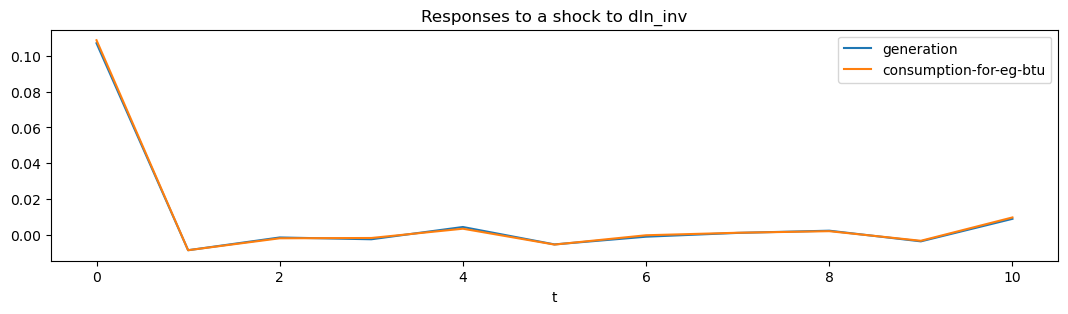

In [512]:
ax = fitted_model.impulse_responses(10, orthogonalized = True).plot(figsize = (13, 3))
ax.set(xlabel = 't', title = 'Responses to a shock to dln_inv')

In [513]:
n_forecast = 45
predict = fitted_model.get_prediction(start = len(train_ff_df), end = len(train_ff_df) + n_forecast - 1)
predictions = predict.predicted_mean

In [514]:
predictions.columns = ['generation_pred', 'consumption-for-eg-btu_pred']
predictions

,generation_pred,consumption-for-eg-btu_pred
2019-04-01,0.201968,0.201943
2019-05-01,0.302366,0.296313
2019-06-01,0.223453,0.215397
2019-07-01,0.238260,0.229840
2019-08-01,0.247518,0.239614
2019-09-01,0.176753,0.167144
2019-10-01,0.254592,0.243360
2019-11-01,0.224167,0.214514
2019-12-01,0.226023,0.215638
2020-01-01,0.214900,0.202972


In [515]:
test_ff_df

,generation,consumption-for-eg-btu
period,,
2019-04-01,0.085411,0.075454
2019-05-01,0.114242,0.108241
2019-06-01,0.046739,0.052913
2019-07-01,0.231182,0.204175
2019-08-01,0.538244,0.501746
2019-09-01,0.210011,0.197558
2019-10-01,0.397660,0.369532
2019-11-01,0.250589,0.235366
2019-12-01,0.108776,0.088757


In [516]:
test_vs_pred = pd.concat([test_ff_df, predictions], axis = 1)

In [517]:
test_vs_pred

,generation,consumption-for-eg-btu,generation_pred,consumption-for-eg-btu_pred
2019-04-01,0.085411,0.075454,0.201968,0.201943
2019-05-01,0.114242,0.108241,0.302366,0.296313
2019-06-01,0.046739,0.052913,0.223453,0.215397
2019-07-01,0.231182,0.204175,0.238260,0.229840
2019-08-01,0.538244,0.501746,0.247518,0.239614
2019-09-01,0.210011,0.197558,0.176753,0.167144
2019-10-01,0.397660,0.369532,0.254592,0.243360
2019-11-01,0.250589,0.235366,0.224167,0.214514
2019-12-01,0.108776,0.088757,0.226023,0.215638
2020-01-01,0.313069,0.277869,0.214900,0.202972


<Axes: >

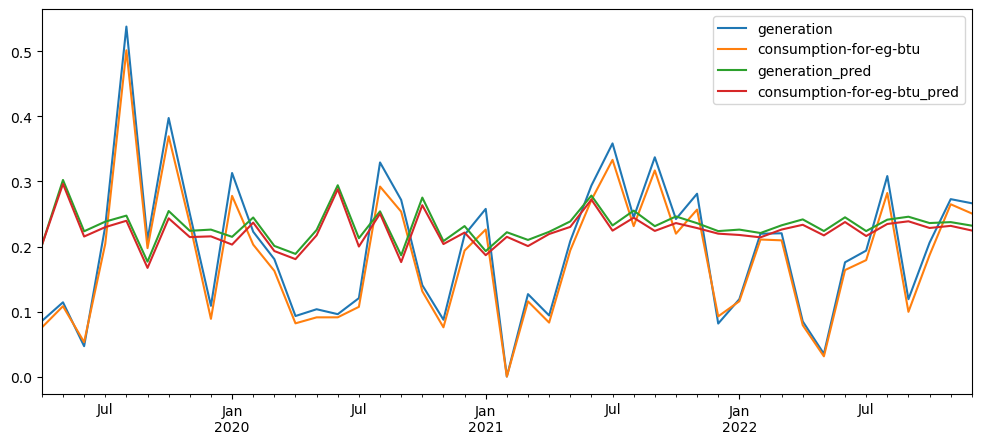

In [518]:
test_vs_pred.plot(figsize = (12, 5))